### Imports

In [1]:
%load_ext PWE_NB_Extension

In [2]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.visualize import PWEVisualization
from PW_explorer.helper import pw_slicer, rel_slicer, rel_name_remapper
from PW_explorer.export import PWEExport

In [3]:
import os.path
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
import networkx as nx

### Helper Python Code

In [4]:
def get_edge_facts(pw, edge_rel_idx):
    """
    Converts the tog/2 into e/2 edges and exports the PW as a string containing ASP Facts.
    """
    pw_objs = [pw]
    _,_,pw_objs = rel_slicer(None, None, pw_objs, rels_to_use=['tog_2'])
    _, pw_objs, _ = rel_name_remapper(None, pw_objs, None, 
                                      rel_name_map={'tog_2': 'tog{}_2'.format(str(edge_rel_idx))})
    return PWEExport.export_as_asp_facts(pw_objs, include_pw_ids=False)

##### Refinement Functions

In [5]:
def get_refinement_rels(objs, refinement_check_func):
    """
    This function finds the set of all refinement relations between all the PWs
    """
    refinement_rels = []
    for i, pw_1 in enumerate(objs):
        for j, pw_2 in enumerate(objs):
            if i == j:
                continue
            if refinement_check_func(pw_1, pw_2):
                refinement_rels.append((pw_1.pw_id, pw_2.pw_id))
    return refinement_rels


def refinement_check(pw1, pw2, refinement_check_encoding):
    """
    This function checks if PW1 is a refinement of PW2 using a given encoding of 
    the refinement relation to use.
    """
    pw1_edge_facts = get_edge_facts(pw1, 1)
    pw2_edge_facts = get_edge_facts(pw2, 2)
    # print(pw1_edge_facts, pw2_edge_facts)
    asp_out, _ = run_clingo(refinement_check_encoding.split('\n')+pw1_edge_facts+pw2_edge_facts, num_solutions=1)
    # print(asp_out)
    _,_,eq_check_pws = load_worlds(asp_out, silent=True)
    
    return len(eq_check_pws) >= 1

##### Efficient Grouping Functions

In [6]:
def get_equivalent_sets(objs, match_func):
    """
    This function efficiently computes the disjoint sets of equivalent 
    PWs using the given match_func
    """
    sets = []
    curr_iter_set = list(range(len(objs)))
    while len(curr_iter_set) > 0:
        next_iter_set = []
        seed = curr_iter_set[0]
        curr_set = {objs[seed]}
        for c in curr_iter_set[1:]:
            if match_func(objs[seed], objs[c]):
                curr_set.add(objs[c])
            else:
                next_iter_set.append(c)
        sets.append(curr_set)
        curr_iter_set = next_iter_set
    return sets


def are_equivalent_patterns(pw1, pw2, eq_check_encoding):
    """
    This function checks if PW1 and PW2 are equivalent based on the equivalence 
    function defined by eq_check_encoding
    """    
    pw1_edge_facts = get_edge_facts(pw1, 1)
    pw2_edge_facts = get_edge_facts(pw2, 2)
    # print(pw1_edge_facts, pw2_edge_facts)
    asp_out, _ = run_clingo(eq_check_encoding.split('\n')+pw1_edge_facts+pw2_edge_facts, num_solutions=1)
    # print(asp_out)
    _,_,eq_check_pws = load_worlds(asp_out, silent=True)
    
    return len(eq_check_pws) >= 1

## Partitions Encoding

We can encode partitions of n (named) objects in Datalog as follows (here n=4):

In [7]:
%%clingo --donot-display_input

% Define the n objects.
obj(1..4).

% Generate "equivalence" between objects
tog(A,B) ; not tog(A,B) :- obj(A), obj(B), A!=B.

% Define symmetric property between equivalent objects
tog(A,B) :- tog(B,A).

% Define transitivity property between the equivalent objects
tog(A,B) :- tog(A,C), tog(C,B), A!=B, B!=C, A!=C.

Output:


'Answer: 1\nobj(1) obj(2) obj(3) obj(4)\nAnswer: 2\nobj(1) obj(2) obj(3) obj(4) tog(4,2) tog(2,4)\nAnswer: 3\nobj(1) obj(2) obj(3) obj(4) tog(4,3) tog(3,4)\nAnswer: 4\nobj(1) obj(2) obj(3) obj(4) tog(3,2) tog(2,3)\nAnswer: 5\nobj(1) obj(2) obj(3) obj(4) tog(3,2) tog(4,2) tog(2,3) tog(4,3) tog(2,4) tog(3,4)\nAnswer: 6\nobj(1) obj(2) obj(3) obj(4) tog(4,1) tog(1,4)\nAnswer: 7\nobj(1) obj(2) obj(3) obj(4) tog(4,1) tog(3,2) tog(2,3) tog(1,4)\nAnswer: 8\nobj(1) obj(2) obj(3) obj(4) tog(3,1) tog(1,3)\nAnswer: 9\nobj(1) obj(2) obj(3) obj(4) tog(3,1) tog(4,2) tog(1,3) tog(2,4)\nAnswer: 10\nobj(1) obj(2) obj(3) obj(4) tog(3,1) tog(4,1) tog(1,3) tog(4,3) tog(1,4) tog(3,4)\nAnswer: 11\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(1,2)\nAnswer: 12\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(1,2) tog(4,3) tog(3,4)\nAnswer: 13\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(3,1) tog(1,2) tog(3,2) tog(1,3) tog(2,3)\nAnswer: 14\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(4,1) tog(1,2) tog(4,2) tog(1,4) tog(2,4)\nAnswer: 15\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(3,1) tog(4,1) tog(1,2) tog(3,2) tog(4,2) tog(1,3) tog(2,3) tog(4,3) tog(1,4) tog(2,4) tog(3,4)\nSATISFIABLE\n\nModels       : 15\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

An equivalent way to encode this shown below. Note that the encoding above uses the "Generate-Define" protocol while the one below uses a "Generate-Test" approach.

In [8]:
%%clingo --donot-display_input -exp partitions

% Define the n objects.
obj(1..4).

% Generate "equivalence" between objects
tog(A,B) ; not tog(A,B) :- obj(A), obj(B), A!=B.

% Test that the symmetric property between equivalent objects holds
:- tog(A,B), not tog(B,A).

% Test that the transitivity property between the equivalent objects holds
:- not tog(A,B), tog(A,C), tog(C,B), A!=B, B!=C, A!=C.

% Define some graphviz annotation for quick visualizations

%graphviz graph graph_type=undirected rankdir=TB
%graphviz edge tog(HEAD, TAIL)
%graphviz node obj(N) colorscheme=pastel28 color=$1 style=filled

Output:


'Answer: 1\nobj(1) obj(2) obj(3) obj(4)\nAnswer: 2\nobj(1) obj(2) obj(3) obj(4) tog(3,1) tog(1,3)\nAnswer: 3\nobj(1) obj(2) obj(3) obj(4) tog(3,2) tog(2,3)\nAnswer: 4\nobj(1) obj(2) obj(3) obj(4) tog(4,1) tog(1,4)\nAnswer: 5\nobj(1) obj(2) obj(3) obj(4) tog(4,1) tog(3,2) tog(2,3) tog(1,4)\nAnswer: 6\nobj(1) obj(2) obj(3) obj(4) tog(4,2) tog(2,4)\nAnswer: 7\nobj(1) obj(2) obj(3) obj(4) tog(3,1) tog(4,2) tog(1,3) tog(2,4)\nAnswer: 8\nobj(1) obj(2) obj(3) obj(4) tog(4,3) tog(3,4)\nAnswer: 9\nobj(1) obj(2) obj(3) obj(4) tog(3,2) tog(4,2) tog(2,3) tog(4,3) tog(2,4) tog(3,4)\nAnswer: 10\nobj(1) obj(2) obj(3) obj(4) tog(3,1) tog(4,1) tog(1,3) tog(4,3) tog(1,4) tog(3,4)\nAnswer: 11\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(1,2)\nAnswer: 12\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(4,1) tog(1,2) tog(4,2) tog(1,4) tog(2,4)\nAnswer: 13\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(1,2) tog(4,3) tog(3,4)\nAnswer: 14\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(3,1) tog(1,2) tog(3,2) tog(1,3) tog(2,3)\nAnswer: 15\nobj(1) obj(2) obj(3) obj(4) tog(2,1) tog(3,1) tog(4,1) tog(1,2) tog(3,2) tog(4,2) tog(1,3) tog(2,3) tog(4,3) tog(1,4) tog(2,4) tog(3,4)\nSATISFIABLE\n\nModels       : 15\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [9]:
partitions['pw_rel_dfs'], partitions['rel_schema'], partitions['pw_objs'] = load_worlds(partitions['asp_soln'],
                                                                                        partitions['meta_data'])



Number of Models: 15


We can visualize these partitions very simply using PWE's built-in visualization function:

PW: 1


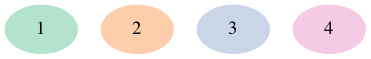

PW: 2


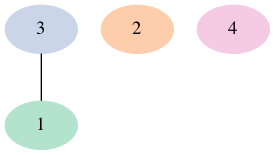

PW: 3


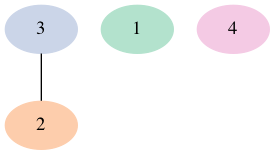

PW: 4


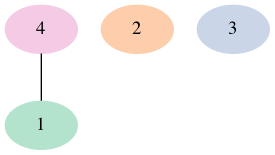

PW: 5


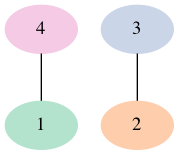

PW: 6


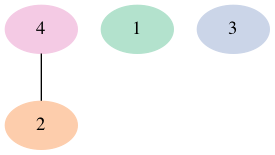

PW: 7


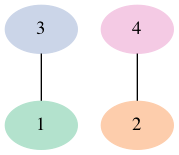

PW: 8


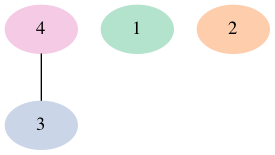

PW: 9


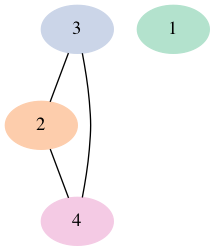

PW: 10


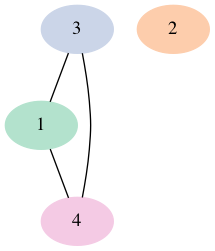

PW: 11


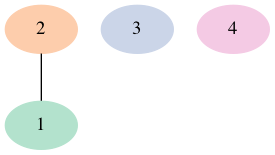

PW: 12


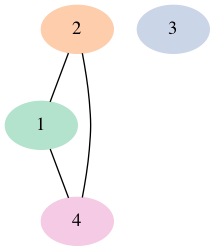

PW: 13


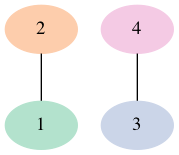

PW: 14


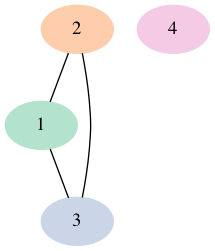

PW: 15


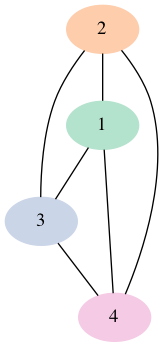

In [10]:
for i in range(1, len(partitions['pw_objs'])+1):
    print("PW:", i)
    v = PWEVisualization.graphviz_from_meta_data(pw_slicer(partitions['pw_rel_dfs'], None, [i])[0], 
                                                 partitions['meta_data']['graphviz'])
    draw(v, filename='Partitions-Viz/partition_{}.png'.format(i), show=False)
    display(draw(v))

### Named to Un-Named

Above we saw that for n we get B<sub>n</sub> (Bell-Number) of PWs. If the objects were unnamed, we could group these PWs using a simple isomorphism based equivalence grouping function. The number of such disjoint groups would then be the number of integer partitions of n.

##### Encoding Isomorphism

In [11]:
%%clingo --donot-display_input -lci partition_eq_check --donot-run

% e(X,Y) :- e(Y,X). --> only if undirected
gnode1(X) :- tog1(X,_).
gnode1(X) :- tog1(_,X).

gnode2(X) :- tog2(X,_).
gnode2(X) :- tog2(_,X).

vmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).
:- vmap(X1,Y1), vmap(X2,Y2), tog1(X1,X2), not tog2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not tog1(X1,X2), tog2(Y1,Y2).

:- gnode1(X), #count {Y: vmap(X,Y)} != 1.
:- gnode2(Y), #count {X: vmap(X,Y)} != 1.

#show.
% #show vmap/2.

With those in place, we can find the disjoint sets of partitions, each of which are equivalent within themselves modulo renaming:

In [12]:
sets = get_equivalent_sets(partitions['pw_objs'], 
                           lambda pw1, pw2: are_equivalent_patterns(pw1, pw2, partition_eq_check))

In [13]:
for s in sets:
    print({pw.pw_id for pw in s})

{1}
{2, 3, 4, 6, 8, 11}
{5, 13, 7}
{9, 10, 12, 14}
{15}


As we can see, we found I<sub>n</sub> sets. We can see these sets below and verify the validity of the groupings ourselves:

------------------------------------------------------------
Set: 0


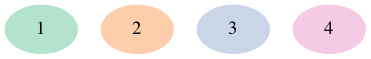

------------------------------------------------------------
------------------------------------------------------------
Set: 1


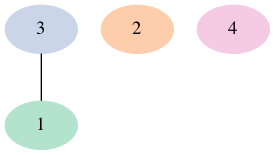

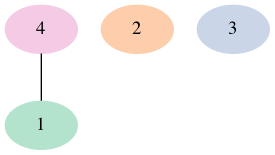

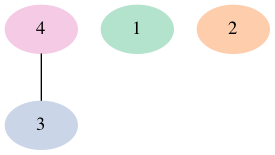

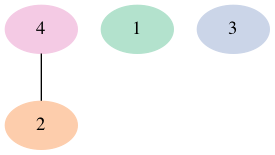

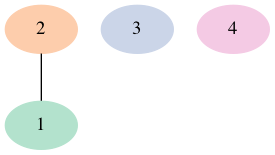

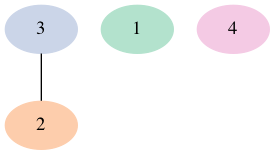

------------------------------------------------------------
------------------------------------------------------------
Set: 2


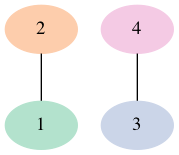

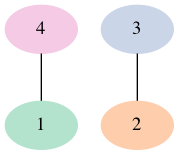

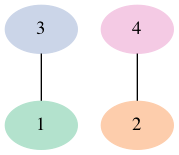

------------------------------------------------------------
------------------------------------------------------------
Set: 3


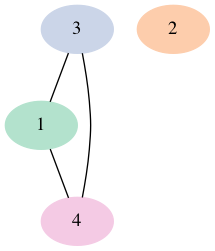

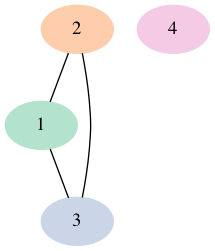

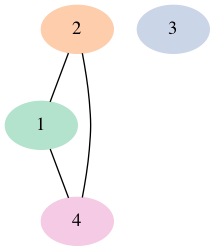

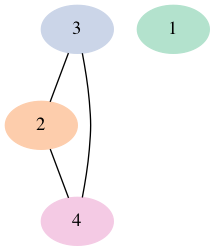

------------------------------------------------------------
------------------------------------------------------------
Set: 4


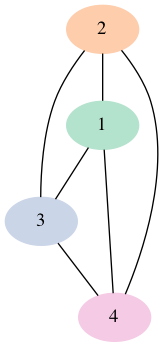

------------------------------------------------------------


In [14]:
for i, s in enumerate(sets):
    print('-'*60)
    print("Set:", i)
    for pw in s:
        display(draw(PWEVisualization.graphviz_from_meta_data(pw_slicer(partitions['pw_rel_dfs'], None, [pw.pw_id])[0], 
                                                              partitions['meta_data']['graphviz'])))
    print('-'*60)

##### As discussed earlier, the number of such sets is the number of integer partitions of n, in this case that is:

In [15]:
# The number of integer partitions of n:
len(sets)

5

### Partial Ordering of the Partitions using a Refinement Relation

We can define a refinement relation to apply a partial ordering to the B<sub>n</sub> partitions. In this scenario, we use a simple refinement relation called the *finer-than* relation, which basically checks if a partition is a further fragmentation of another fragmentation.

We define the *finer-than* relation below in ASP:

In [16]:
%%clingo --donot-display_input -lci finer_than_relation --donot-run

% G1 >= G2

% Get all the nodes
n(X) :- tog1(X,_).
n(X) :- tog1(_,X).
n(X) :- tog2(X,_).
n(X) :- tog2(_,X).

% Check if all edges in G2 are also in G1
:- not tog1(X,Y), tog2(X,Y), n(X), n(Y).

Now, using this refinement relation, we can find all pairs of PWs such that one is a refinement of the other.

In [17]:
pw_refinement_rels = get_refinement_rels(partitions['pw_objs'],
                                         lambda pw1, pw2: refinement_check(pw1, pw2, finer_than_relation))

To visualize this ordering, we can use a graph-based visualization:

In [18]:
G = nx.DiGraph()
G.add_edges_from(pw_refinement_rels)
# Applying some custom Graphviz styling, along with images of the partitions in the nodes
for pw in partitions['pw_objs']:
    G.add_node(pw.pw_id, image=os.path.abspath('Partitions-Viz/partition_{}.png'.format(pw.pw_id)),
               shape='box', fixedsize='true', imagescale='true', size=2, label=" ")

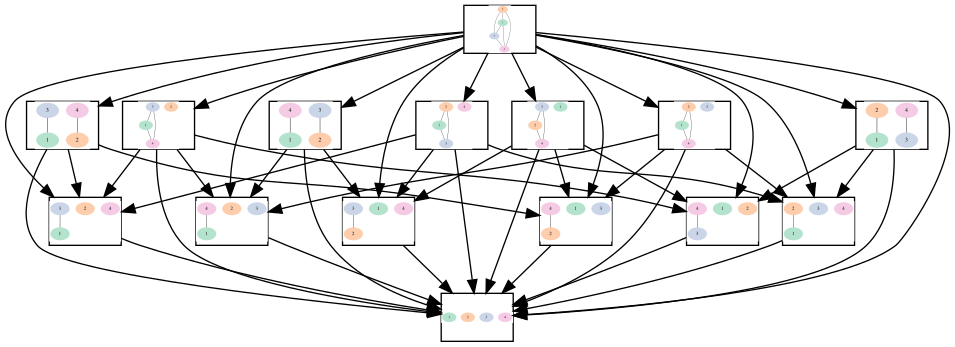

In [19]:
draw(G)

As we can see, there are redundant edges here, i.e. e(A,B), e(A,C), e(B,C), where e(A,B), e(B,C) would suffice. This is called transitive reduction. We can perform it very simply in Python (using the NetworkX library) as shown below.

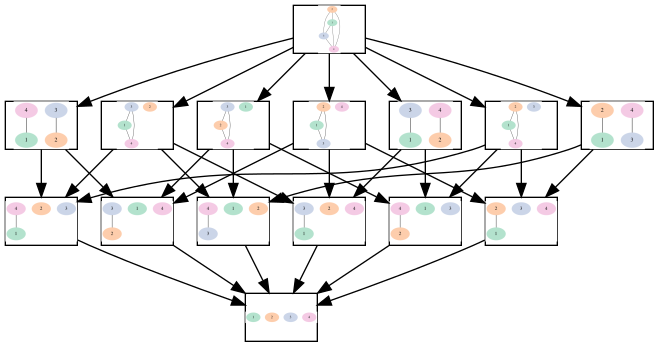

In [20]:
G_trans_redcd = nx.algorithms.dag.transitive_reduction(G)

# Copying over the Graphviz styling from G
for n in G.nodes:
    for k,v in G.nodes[n].items():
        G_trans_redcd.nodes[n][k] = v
draw(G_trans_redcd)

We can also perform this transitive reduction using ASP.

In [21]:
%%clingo --donot-display_input -lci transitive_reduction --donot-run

% Add all transitive edges to the graph (that are not already there)
e(X,Y) :- e(X,Z), e(Z,Y).

% An edge e(X,Y) is redundant if there already exists e(X,Z), e(Z,Y) for some Z
tc(X,Y) :- e(X,Z), e(Z,Y).

% Only keep non-redundant edges
new_e(X,Y) :- e(X,Y), not tc(X,Y).

%graphviz graph graph_type=directed
%graphviz edge new_e(HEAD, TAIL)

#show new_e/2.

To use the above encoding, we must first enlist the edges of graph G above as Datalog Facts.

In [22]:
refinement_rel_edges = ' '.join(['e({},{}).'.format(*e) for e in G.edges])

Now, we can get the set of edges after transitive reduction using the encoding and our list of edges.

In [23]:
%clingo -l refinement_rel_edges transitive_reduction --donot-display_input -exp trans_redc_edges

Output:


'Answer: 1\nnew_e(2,1) new_e(3,1) new_e(4,1) new_e(5,3) new_e(5,4) new_e(6,1) new_e(7,2) new_e(7,6) new_e(8,1) new_e(9,3) new_e(9,6) new_e(9,8) new_e(10,2) new_e(10,4) new_e(10,8) new_e(11,1) new_e(12,4) new_e(12,6) new_e(12,11) new_e(13,8) new_e(13,11) new_e(14,2) new_e(14,3) new_e(14,11) new_e(15,5) new_e(15,7) new_e(15,9) new_e(15,10) new_e(15,12) new_e(15,13) new_e(15,14)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

In [24]:
trans_redc_edges['pw_rel_dfs'], trans_redc_edges['rel_schema'], trans_redc_edges['pw_objs'] = load_worlds(trans_redc_edges['asp_soln'], 
                                                                                                          trans_redc_edges['meta_data'])

Number of Models: 1


We can now visualize the output of performing transitive reduction.

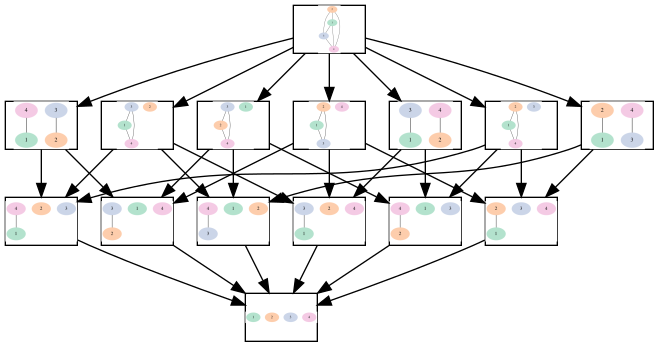

In [25]:
G_trans_redcd_asp = PWEVisualization.graphviz_from_meta_data(trans_redc_edges['pw_rel_dfs'],
                                                             trans_redc_edges['meta_data']['graphviz'])
# Copy over Graphviz Styling
for n in G.nodes:
    for k,v in G.nodes[n].items():
        G_trans_redcd_asp.nodes[str(n)][k] = v
draw(G_trans_redcd_asp)

As we can see, the output is the same as using the Python 'blackbox' version.

Another interesting observation is that the different disjoint groups we found by using isomorphisms can all almost be seen distinctly on the different BFS-level of the graph.